In [1]:
import copy
import tqdm
import random
import numpy as np
from icecream import ic
from deap import base, creator, tools, algorithms
from dataclasses import dataclass, field
from bandgap.Truss_mesh import Truss_mesh
from bandgap.Symmetry_Map_FBZ import Symmetry_Map_FBZ
from bandgap.wave_vector import wave_vector
from bandgap.band_gap import band_gap
from bandgap.plot_structure import plot_structure

import uuid

In [ ]:
# Definir la clase del individuo utilizando dataclass
@dataclass
class Individual:
    # id: int = field(init=False, default=0)
    # _id_counter: int = 0
    
    genes: np.ndarray
    age: int = 0
    ym1: float = 70e9
    ym2: float = 411e9
    d1: float = 2.7e3
    d2: float = 19.3e3
    D1: float = 0.004
    n: int = 3
    data_plot = None
    bandgap = None
    data_bandgap = None
    
    def __post_init__(self):
        self.D2 = self.D1 * 2
        self.A1 = np.pi * (self.D1 ** 2) / 4
        self.A2 = np.pi * (self.D2 ** 2) / 4

        # type(self)._id_counter += 1
        # self.id = type(self)._id_counter
 
    def __eq__(self, other):
        return np.array_equal(self.genes, other.genes)
        
    def evaluate(self):
        
        self.bandgap, self.data_bandgap = self.bands()
        
        less = 10000 if self.bandgap <0.1 else 0 
        
        points = self.bandgap - less
        
        #return np.sum(self.genes),
        return points,

    def mutate(self, flippd):
        flip_bit = lambda x: 1 - x
        genes = self.genes.reshape(1,-1)
        
        for i, gen in enumerate(genes):
            random_value = random.random()
            if random_value<=flippd:
                genes[i] = flip_bit(gen)
        
        self.genes = genes.reshape(2, 12)
            
        #mutation_idx = random.randint(0, IND_SIZE - 1)
        #self.genes[mutation_idx] = random.uniform(0, 1)
        return self,
    
    def clone(self):
        return copy.deepcopy(self)
    
    def increment_age(self):
        self.age += 1

    def bands(self):
        Lac = 0.025
        Lpc = Lac
        nc = 4
        nx = nc
        ny = nc
        Lc = Lpc*nc
        Lx = Lc
        Ly = Lc
        
        nn, ne, coord, connect = Truss_mesh(Lx,nx,Ly,ny)
        
        S = Symmetry_Map_FBZ(nc)
        nxred = S.shape[1]
        
        xa = self.genes[0,:]
        xm = self.genes[1,:]
        
        xm = np.array([xm])
        xa = np.array([xa])
        
        xm = xm.T
        xa = xa.T
        
        xf = np.vstack((xm, xa))
        
        x = np.round(xf)
        
        xm = x[:nxred]
        xa = x[nxred:2*nxred]
        x_mat = np.dot(S, xm)
        x_area = np.dot(S, xa)

        x_expanded = np.hstack((x_mat, x_area))
        
        n = self.n
        
        nav = n + 3
        
        NINT = 20
        
        theta_x, theta_y = wave_vector(NINT,Lx,Ly,0)
        
        self.data_plot = ne,connect,coord,x_area,x_mat
        
        return band_gap(self, n, Lx, Ly, nx, ny, ne, coord, connect, x_expanded, nav, theta_x, theta_y)
    
    def structure(self):
        plot_structure(*self.data_plot)
        

def mate(ind1, ind2, n):
    columns = list(range(IND_SIZE))  # Crear una lista de índices de columnas
    crossover_points = random.sample(columns, n)  # Seleccionar n índices de columna aleatorios
    
    for point in crossover_points:
        ind1.genes[:, point], ind2.genes[:, point] = ind2.genes[:, point], ind1.genes[:, point]
    
    return ind1, ind2

# Función de selección
def select(individuals, k):
    return tools.selTournament(individuals, k, tournsize=5)

# Definir los parámetros del problema
IND_SIZE = 12  # Número de genes en cada individuo

# Crear los tipos de fitness e individuo en DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", Individual, fitness=creator.FitnessMax)

# Configuración del entorno evolutivo utilizando DEAP
toolbox = base.Toolbox()

# Registro de las funciones
toolbox.register("attr_float", random.uniform, 0, 1)
#toolbox.register("individual", lambda: creator.Individual(genes=np.array([random.uniform(0, 1) for _ in range(IND_SIZE)])))
toolbox.register("individual", lambda: creator.Individual(np.array([[random.choice([0, 1]) for _ in range(IND_SIZE)] for _ in range(2)])))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", lambda ind: ind.evaluate())
toolbox.register("mutate", lambda ind: ind.mutate(0.7))
toolbox.register("clone", lambda ind: ind.clone())
toolbox.register("mate", mate, n=6)
toolbox.register("select", select)

# Función principal para ejecutar el algoritmo genético
def main():
    #random.seed(42)

    # Configuración del algoritmo
    n_pop = 10
    pop = toolbox.population(n=n_pop)
    num_generations = 20
    hall_of_fame = tools.HallOfFame(1)

    # Definir estadísticas
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    

    # Definir el logbook
    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + stats.fields

    # Algoritmo evolutivo
    with tqdm.tqdm(total=num_generations) as pbar:
        for gen in range(num_generations):
            # Evaluar individuos
            invalid_ind = [ind for ind in pop if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            # Registrar estadísticas
            if gen % 10 == 0 or gen == num_generations - 1:
                record = stats.compile(pop)
                logbook.record(gen=gen, nevals=len(invalid_ind), **record)

            # Seleccionar los siguientes individuos
            offspring = toolbox.select(pop, int(n_pop/4))
            offspring = list(map(toolbox.clone, offspring))

            # Aplicar cruce y mutación usando varAnd
            offspring = algorithms.varAnd(offspring, toolbox, cxpb=0.5, mutpb=1)

            # Reemplazar la población actual con la nueva generación
            pop[:] = offspring

            # Incrementar la edad de cada individuo
            for ind in pop:
                ind.increment_age()
            
            hall_of_fame.update(pop)
            pbar.update(1)

    return pop, logbook, hall_of_fame

# Ejecutar la función principal
pop, logbook, hall_of_fame = main()

# Mostrar el último estado del logbook
print(logbook)

best_individual = hall_of_fame[0]
print(f"Best individual age: {best_individual.age}")

c:\Users\ijara\.conda\envs\bandgap-py\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\ijara\.conda\envs\bandgap-py\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
100%|██████████| 20/20 [00:02<00:00,  8.39it/s]

gen	nevals	avg     	std     	min     	max     
0  	10    	-9002.43	3001.14 	-10006.7	0.995358
10 	2     	-10001.1	0.595489	-10001.7	-10000.5
19 	2     	-10000.5	0       	-10000.5	-10000.5
Best individual age: 1


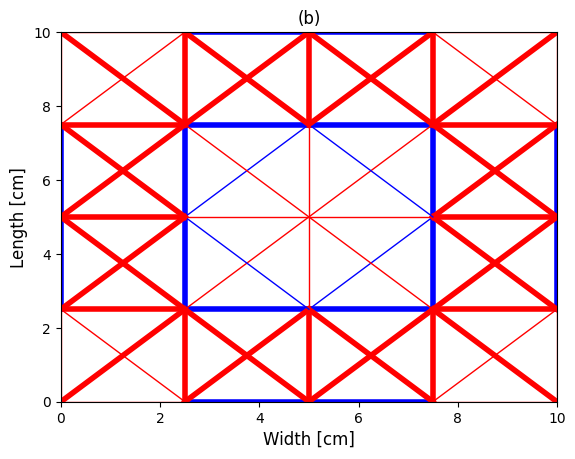

-3.5644170874201038


In [ ]:
best_individual.structure()
print(best_individual.bands())

In [23]:
for i in pop:
    print(i)

Individual(genes=array([[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0]]), age=20, ym1=70000000000.0, ym2=411000000000.0, d1=2700.0, d2=19300.0, D1=0.004, n=3)
Individual(genes=array([[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0]]), age=20, ym1=70000000000.0, ym2=411000000000.0, d1=2700.0, d2=19300.0, D1=0.004, n=3)
